# Likelihood Estimation

_Author: Valentin Pratz_

The likelihood function $p(x|\theta)$ describes the distribution of data $x$ conditional on parameters $\theta$.
While posterior estimation is the predominant use-case in BayesFlow, estimating likelihoods is possible as well.
There are two main motivations to approximate a likelihood.
First, one might want to estimate the _density_ of data $x$ for given parameters $\theta$, which is not possible if one only has access to a simulator.
Second, one might want to train an approximate _synthetic likelihood_ for faster sampling, leveraging the interpolation capacities of neural networks.

Performing likelihood estimation instead of posterior estimation requires only minor modifications to the pipeline.
We will demonstrate the basic steps on a simple toy example below.
If you have an idea for a more interesting case study, please make a pull request or reach out to us.

## Toy Example

We will use a very simple toy example, a bi-modal distribution obtained by mirroring a two-dimensional Gaussian at the origin. For simplicity, we only use the mean as a parameter, and use a fixed diagonal covariance matrix.

In [1]:
import os

if not os.environ.get("KERAS_BACKEND"):
    # Set to your favorite backend
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import bayesflow as bf

INFO:2026-01-19 14:00:00,265:jax._src.xla_bridge:867: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/jonas.arruda/miniconda/envs/BayesFlow/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/jonas.arruda/miniconda/envs/BayesFlow/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:bayesflow:Using backend 'jax'


In [3]:
rng = np.random.default_rng()

In [4]:
def likelihood(theta):
    loc = theta if rng.random() > 0.5 else -theta
    return {"x": rng.normal(loc=loc, scale=0.2, size=theta.shape)}

The likelihood $p(x|\theta)$ is conditional on $\theta$. As we know how we can produce as simulations, we can already look at samples from the likelihood for a given $\theta$. The simulator serves as an _implicit likelihood_. Below, we specify the simulator with a fixed parameter that is passed to the likelihood function. We can then sample from the likelihood, and plot the resulting samples.

In [5]:
theta_0 = np.array([1.0, 1.0])

def params():
    return {"theta": theta_0}

simulator = bf.make_simulator([params, likelihood])

In [6]:
sims = simulator.sample(5000)
sims["x"].shape

(5000, 2)

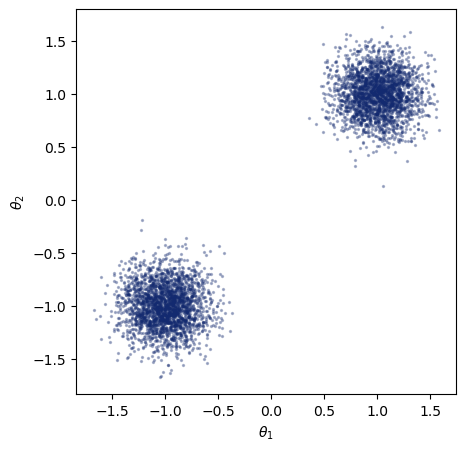

In [7]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*sims["x"].T, s=2, alpha=0.3, color="#132a70")
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_aspect("equal", "box")

While we could use those samples to produce an estimation of the likelihood for this specific parameter value, we often want to obtain an estimation for a range of parameter values. Similar to the prior distribution in posterior estimation, we can specify a function that randomly produces parameter values we are interested in. 

As we are estimating the likelihood $p(x|\theta)$, which is conditional on $\theta$, how this function looks like will not change the "ground truth" we aim to estimate. In contrast, changing the prior in posterior estimation also changes the true posterior.

In practice, different choices of this function can lead to different approximation results, as it determines how many simulations the approximator sees for each parameter region. Here, we choose a uniform distribution in the range from -2 to 2.

In [8]:
def params():
    theta = rng.uniform(-2, 2, (2,))
    return {"theta": theta}

simulator = bf.make_simulator([params, likelihood])

## Training

We are now ready to do the actual likelihood estimation. We want to learn the likelihood of the data $x$ conditional on the parameters $\theta$. Therefore, we use the parameters as `inference_conditions`, and the data as `inference_variables`. We do not use a summary network, so no `summary_conditions` are present. We can use a `BasicWorkflow`, which allows us to easily specify the necessary parameters.

`CouplingFlow`s are nice, because they enable fast sampling and likelihood evaluation, but they can struggle with multimodal distributions. Therefore, we will use a diffusion model at the cost of largely increased inference time. What one would choose in practice depends on the speed-accuracy trade-off.

Accurate likelihood approximation can require a lot of training samples, especially when the distributions are complex and high-dimensional!

In [9]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    inference_network=bf.networks.DiffusionModel(),
    inference_variables="x",
    inference_conditions="theta",
    initial_learning_rate=1e-3,
    standardize=None
)

Training will take around 2 minutes using JAX on a CPU.

In [10]:
history = workflow.fit_online(epochs=30, num_batches_per_epoch=500, batch_size=64, validation_data=1024)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.8132 - val_loss: 1.5928
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.3817 - val_loss: 1.2347
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2465 - val_loss: 1.1200
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2133 - val_loss: 1.0925
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2353 - val_loss: 1.2219
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2647 - val_loss: 1.0182
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.3412 - val_loss: 0.9190
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2433 - val_loss: 1.0610
Epoch 9/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.1952 - val_loss: 1.1668
Epoch 10/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2226 - val_loss: 1.2218
Epoch 11/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2110 - val_loss: 1.0065
Epoch 12/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

INFO:bayesflow:Training completed in 2.12 minutes.


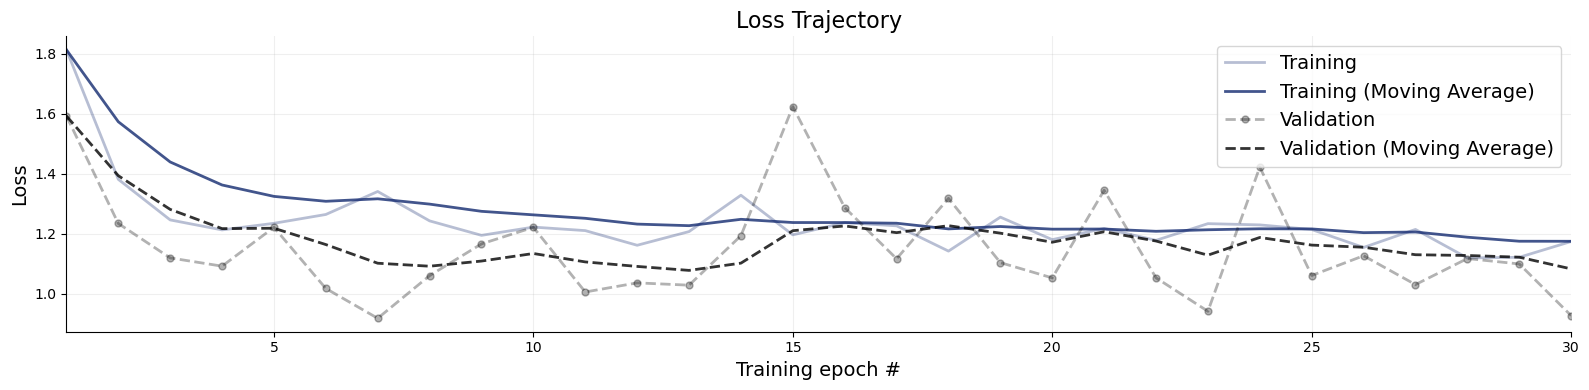

In [11]:
f = bf.diagnostics.plots.loss(history)

## Evaluation

We can now sample from the approximate likelihood by specifying $\theta_0$ as the condition. Generating 5000 samples from the approximate likelihood should take around 2 seconds using JAX on CPU.

In [12]:
%%time
approx_samples = workflow.sample(num_samples=5000, conditions={"theta": theta_0[None]})

Sampling:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:bayesflow:Sampling completed in 9.37 seconds.


CPU times: user 40.4 s, sys: 1.2 s, total: 41.6 s
Wall time: 9.37 s


In [13]:
approx_samples['x'].shape

(1, 5000, 2)

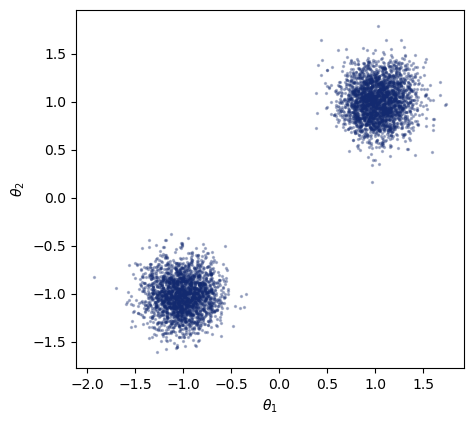

In [14]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*approx_samples["x"][0].T, s=2, alpha=0.3, color="#132a70")
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_aspect("equal", "box")

You might have noticed that we could already sample before training, as we needed this to actually train our model.
Now, with the trained model, we can evaluate the likelihood density as well, which was not possible before.
Below, we make a two-dimensional plot of the density for a given set of parameters.

In [15]:
nx_1, nx_2 = (25, 25)
x_1 = np.linspace(-2, 2, nx_1)
x_2 = np.linspace(-2, 2, nx_2)
vx_1, vx_2 = np.meshgrid(x_1, x_2)
xvals = np.stack([np.reshape(vx_1, (-1,)), np.reshape(vx_2, (-1,))], axis=-1)

In [ ]:
log_density = workflow.log_prob(data={"x": xvals, "theta": np.repeat(theta_0[None], xvals.shape[0], axis=0),})

INFO:bayesflow:Computing log probability completed in 6.62 seconds.


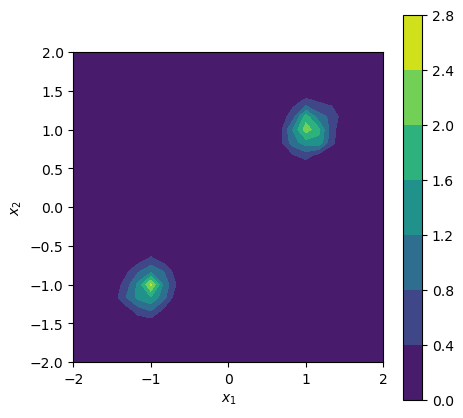

In [19]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
cf = ax.contourf(x_1, x_2, np.reshape(np.exp(log_density), (nx_1, nx_2)))
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal", "box")
cbar = f.colorbar(cf, ax=ax)

## Further Steps

In this notebook, we presented the fundamentals of likelihood estimation with BayesFlow, but did not go into much detail regarding training details or network architectures.
In practice, we advise to start with a simpler inference network like `CouplingFlow`s, and a moderate amount of training samples.
To improve performance, you can experiment with hyperparameters (learning rate, batch size, epochs, ...), and, depending on your setting, increase the number of training samples or move to a slower but more expressive architecture like `FlowMatching` or `DiffusionModel`.